In [1]:
import numpy as np 
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt 
import PIL 

In [2]:
from tensorflow import  keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential

# Visualizing MNIST dataset 

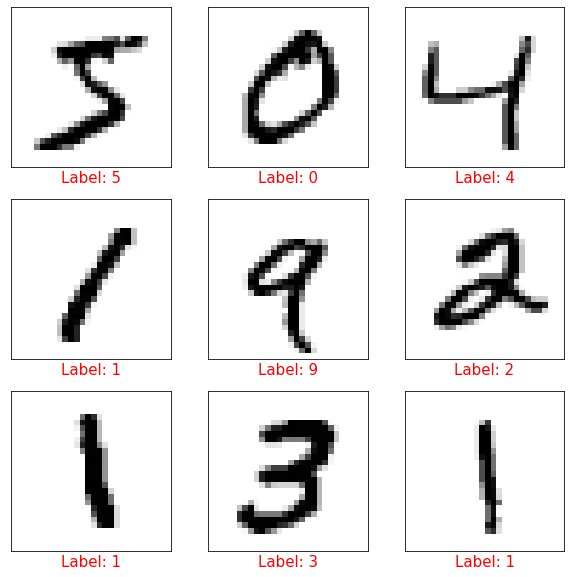

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


# defining classes 
class_names= np.arange(0, 10)


plt.figure(figsize=(10, 10))
for i in range(9): 
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(f'Label: {class_names[y_train [i]]}', c= 'r', fontsize=15)
    plt.xticks([])
    plt.yticks([])


# Load official dataset 

In [4]:
mnist_dataset, mnist_info= tfds.load(name= 'mnist', with_info=True,as_supervised=True) 

In [5]:
mnist_train, mnist_test= mnist_dataset['train'], mnist_dataset['test']   # extract train and test dataset 


In [6]:

# number of validation samples 
num_validation_samples= 0.1 * mnist_info.splits['train'].num_examples     # size of validation dataset                                                                  
num_validation_samples= tf.cast(num_validation_samples, tf.int64) # converting validation sample size into integer


# number of test samples 
num_test_samples= mnist_info.splits['test'].num_examples 
num_test_samples= tf.cast(num_test_samples, tf.int64)

# Preprocessing 

## Shuffling and configuring for performance 

In [7]:
AUTOTUNE= tf.data.AUTOTUNE

mnist_train= mnist_train.cache().shuffle(1000).prefetch(buffer_size= AUTOTUNE)
mnist_test= mnist_test.cache().prefetch(buffer_size= AUTOTUNE)

## Get the train, validation, test splits

In [8]:
test_data=  mnist_test 

validation_data= mnist_train.take(num_validation_samples) 

train_data= mnist_train.skip(num_validation_samples)

## Standardizing the data using standardizing layer 

In [9]:
normalization_layer = layers.Rescaling(1.0/255.0)

## Creating batches for training data 

In [10]:
BATCH_SIZE= 100 

In [11]:
train_data= train_data.batch(BATCH_SIZE) 
validation_data= validation_data.batch(num_validation_samples) # single batched validation data 
test_data = test_data.batch(num_test_samples)  # single batched test data 

In [12]:
validation_inputs, validation_outputs= next(iter(validation_data))

# The model 



In [13]:
img_height= 28 
img_width = 28 
num_channel= 1 

## Stack the layers 

In [14]:
num_classes= len(class_names)


model= Sequential([  
    layers.Rescaling(1./255, input_shape=(img_height, img_width, num_channel)), 
    layers.Conv2D(16, 3, padding='same', activation='relu'), 
    layers.MaxPooling2D(), 
    layers.Conv2D(32,3 , padding='same',activation= 'relu'), 
    layers.MaxPooling2D(), 
    layers.Conv2D(64, 3, padding='same', activation= 'relu'), 
    layers.MaxPooling2D(), 
    layers.Conv2D(128, 3, padding='same', activation= 'relu'), 
    layers.MaxPooling2D(), 
    layers.Flatten(),
    layers.Dense(128, activation= 'relu'), 
    layers.Dense(num_classes)

])

## Compile the model 

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model 

In [16]:
epochs = 10 


history= model.fit(train_data, epochs=epochs, validation_data= (validation_inputs,validation_outputs ), verbose= 2)

Epoch 1/10
540/540 - 17s - loss: 0.2661 - accuracy: 0.9191 - val_loss: 0.0962 - val_accuracy: 0.9707 - 17s/epoch - 32ms/step
Epoch 2/10
540/540 - 14s - loss: 0.0674 - accuracy: 0.9791 - val_loss: 0.0538 - val_accuracy: 0.9862 - 14s/epoch - 26ms/step
Epoch 3/10
540/540 - 14s - loss: 0.0458 - accuracy: 0.9858 - val_loss: 0.0583 - val_accuracy: 0.9842 - 14s/epoch - 25ms/step
Epoch 4/10
540/540 - 13s - loss: 0.0343 - accuracy: 0.9892 - val_loss: 0.0470 - val_accuracy: 0.9887 - 13s/epoch - 24ms/step
Epoch 5/10
540/540 - 13s - loss: 0.0260 - accuracy: 0.9916 - val_loss: 0.0548 - val_accuracy: 0.9862 - 13s/epoch - 24ms/step
Epoch 6/10
540/540 - 18s - loss: 0.0256 - accuracy: 0.9913 - val_loss: 0.0390 - val_accuracy: 0.9885 - 18s/epoch - 34ms/step
Epoch 7/10
540/540 - 18s - loss: 0.0190 - accuracy: 0.9935 - val_loss: 0.0438 - val_accuracy: 0.9885 - 18s/epoch - 33ms/step
Epoch 8/10
540/540 - 20s - loss: 0.0166 - accuracy: 0.9944 - val_loss: 0.0650 - val_accuracy: 0.9845 - 20s/epoch - 37ms/step


- val_accuracy = 0.9892

## Improvements to make 

### Define Data augmentation layer 

In [17]:
data_augmentation = keras.Sequential([  
    layers.RandomFlip('horizontal', input_shape = (img_height, img_width, num_channel)), 
    layers.RandomRotation(0.1), 
    layers.RandomZoom(0.1)
])

## remaking the model 

In [18]:
# layering 

model= Sequential([  
    data_augmentation, 
    layers.Rescaling(1./255), 
    layers.Conv2D(16, 3, padding='same', activation='relu'), 
    layers.MaxPooling2D(), 
    layers.Conv2D(32,3 , padding='same',activation= 'relu'), 
    layers.MaxPooling2D(), 
    layers.Conv2D(64, 3, padding='same', activation= 'relu'), 
    layers.MaxPooling2D(), 
    layers.Dropout(0.2), 
    layers.Flatten(),
    layers.Dense(128, activation= 'relu'), 
    layers.Dense(num_classes, name='outputs')

])

In [19]:

# compiling 
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
epochs = 10 


history= model.fit(train_data, epochs=epochs, validation_data= (validation_inputs,validation_outputs ), verbose= 2)

Epoch 1/10
540/540 - 22s - loss: 0.6227 - accuracy: 0.7947 - val_loss: 0.2105 - val_accuracy: 0.9327 - 22s/epoch - 40ms/step
Epoch 2/10
540/540 - 21s - loss: 0.2472 - accuracy: 0.9210 - val_loss: 0.1175 - val_accuracy: 0.9612 - 21s/epoch - 39ms/step
Epoch 3/10
540/540 - 23s - loss: 0.1786 - accuracy: 0.9436 - val_loss: 0.1091 - val_accuracy: 0.9672 - 23s/epoch - 43ms/step
Epoch 4/10
540/540 - 26s - loss: 0.1451 - accuracy: 0.9546 - val_loss: 0.0969 - val_accuracy: 0.9698 - 26s/epoch - 47ms/step
Epoch 5/10
540/540 - 22s - loss: 0.1283 - accuracy: 0.9598 - val_loss: 0.0812 - val_accuracy: 0.9750 - 22s/epoch - 40ms/step
Epoch 6/10
540/540 - 19s - loss: 0.1151 - accuracy: 0.9637 - val_loss: 0.0756 - val_accuracy: 0.9757 - 19s/epoch - 36ms/step
Epoch 7/10
540/540 - 19s - loss: 0.1054 - accuracy: 0.9672 - val_loss: 0.0691 - val_accuracy: 0.9802 - 19s/epoch - 35ms/step
Epoch 8/10
540/540 - 20s - loss: 0.0973 - accuracy: 0.9693 - val_loss: 0.0620 - val_accuracy: 0.9807 - 20s/epoch - 38ms/step


# Visualize the training results 

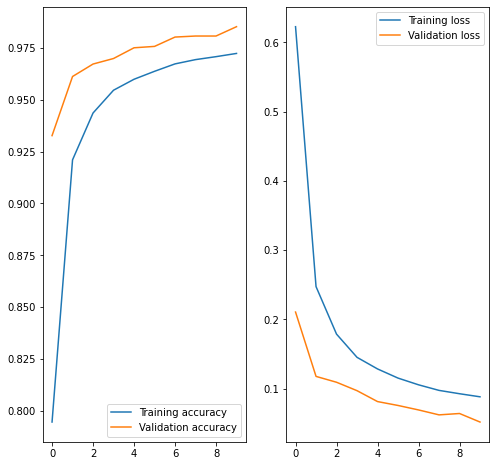

In [21]:
acc= history.history['accuracy'] 
val_acc= history.history['val_accuracy'] 

loss= history.history['loss']
val_loss = history.history['val_loss']  


epochs_range= range(epochs)  

plt.figure(figsize=(8,8))   

plt.subplot(1, 2, 1) 
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label= 'Validation accuracy') 
plt.legend() 
 
plt.subplot(1,2, 2) 
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label= 'Validation loss') 
plt.legend() 
 


Seems like ok 

# Testing the model with test dataset 

In [22]:
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 1s 782ms/step - loss: 0.0421 - accuracy: 0.9859


# Save the model 

In [23]:
!mkdir -p saved_model 
model.save('saved_model/CNN_model')

INFO:tensorflow:Assets written to: saved_model/CNN_model/assets


INFO:tensorflow:Assets written to: saved_model/CNN_model/assets
